In [ ]:
#!test ! -f "master.zip" && wget "https://github.com/karoldvl/ESC-50/archive/master.zip"

In [ ]:
#!unzip -qq master.zip

In [ ]:
#%cd ESC-50-master

In [1]:
from csv import writer
import pickle
import pyaudio
import winsound
import wave
import time
import pandas as pd
import librosa
import cv2
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
#from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm, notebook
import os

In [5]:
# only one time!
folder_data= "./meta/"
seq_num= 100000
pickle.dump(seq_num,open(folder_data + "seq_num.pickle", 'wb'))

In [2]:
df = pd.read_csv('meta/esc50.csv')
df_extr = pd.read_csv('meta/audio_extr.csv')

In [143]:
df.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [144]:
df_extr.head()

,filename,fold,target,category,esc10,src_file,take


In [145]:
df = df.drop(df[(df.category == "dog") | (df.category == "chirping_birds") | (df.category == "thunderstorm") | (df.category == "can_opening") 
                | (df.category == "crow") | (df.category == "clapping") | (df.category == "fireworks") | (df.category == "chainsaw")
                | (df.category == "airplane") | (df.category == "mouse_click") | (df.category == "train") | (df.category == "sheep") 
               | (df.category == "church_bells") | (df.category == "clock_alarm") | (df.category == "keyboard_typing") | (df.category == "wind") 
                | (df.category == "frog") | (df.category == "cow") | (df.category == "car_horn") | (df.category == "crackling_fire") 
                | (df.category == "helicopter") | (df.category == "engine") | (df.category == "pouring_water")  | (df.category == "engine")
               | (df.category == "drinking_sipping") | (df.category == "rain") | (df.category == "insects") | (df.category == "laughing") 
               | (df.category == "hen") | (df.category == "breathing") | (df.category == "crying_baby") | (df.category == "hand_saw")
               | (df.category == "coughing")| (df.category == "insects") | (df.category == "glass_breaking") | (df.category == "snoring")
               | (df.category == "pig") | (df.category == "clock_tick") | (df.category == "footsteps") | (df.category == "rooster")
               | (df.category == "sea_waves") | (df.category == "engine") | (df.category == "sneezing") | (df.category == "siren")
               | (df.category == "cat") | (df.category == "door_wood_creaks") | (df.category == "crickets") | (df.category == "engine")
               | (df.category == "door_wood_knock") | (df.category == "water_drops")].index)
df.reset_index(inplace = True)

In [146]:
pd.set_option('display.max_rows', None)
print (df['category'])

0       vacuum_cleaner
1       vacuum_cleaner
2       brushing_teeth
3       brushing_teeth
4       vacuum_cleaner
5       vacuum_cleaner
6       vacuum_cleaner
7         toilet_flush
8      washing_machine
9      washing_machine
10     washing_machine
11     washing_machine
12     washing_machine
13        toilet_flush
14        toilet_flush
15     washing_machine
16     washing_machine
17      brushing_teeth
18        toilet_flush
19      vacuum_cleaner
20     washing_machine
21        toilet_flush
22        toilet_flush
23        toilet_flush
24        toilet_flush
25      brushing_teeth
26      brushing_teeth
27      vacuum_cleaner
28      brushing_teeth
29      brushing_teeth
30      brushing_teeth
31      vacuum_cleaner
32     washing_machine
33     washing_machine
34     washing_machine
35     washing_machine
36     washing_machine
37      vacuum_cleaner
38      vacuum_cleaner
39     washing_machine
40      vacuum_cleaner
41      vacuum_cleaner
42      vacuum_cleaner
43      vac

In [147]:
df = df.drop(['index'], axis='columns') 
df.head(40)

,filename,fold,target,category,esc10,src_file,take
0,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
1,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
2,1-17092-A-27.wav,1,27,brushing_teeth,False,17092,A
3,1-17092-B-27.wav,1,27,brushing_teeth,False,17092,B
4,1-19840-A-36.wav,1,36,vacuum_cleaner,False,19840,A
5,1-19872-A-36.wav,1,36,vacuum_cleaner,False,19872,A
6,1-19872-B-36.wav,1,36,vacuum_cleaner,False,19872,B
7,1-20736-A-18.wav,1,18,toilet_flush,False,20736,A
8,1-21896-A-35.wav,1,35,washing_machine,False,21896,A
9,1-23996-A-35.wav,1,35,washing_machine,False,23996,A


In [148]:
df_extr.head(40)

,filename,fold,target,category,esc10,src_file,take


In [149]:
print (df_extr['category'])

Series([], Name: category, dtype: object)


In [150]:
train = df[df['fold']!=5]
valid = df[df['fold']==5]

In [151]:
wav, sr = librosa.load('audio/1-20736-A-18.wav', sr=None)
print(f'Sampling rate of the audio is {sr} and length of the audio is {len(wav)/sr} seconds')

Sampling rate of the audio is 44100 and length of the audio is 5.0 seconds


In [152]:
def spec_to_image(spec, eps=1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)    
    return spec_scaled

In [153]:
def spec_to_image_3d(spec, eps=1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.astype(np.uint8)
    # print (np.shape(spec_scaled))
    spec_scaled= cv2.cvtColor(spec_scaled,cv2.COLOR_GRAY2RGB)
    # print (np.shape(spec_scaled))
    return spec_scaled

In [154]:
def get_melspectrogram_db(file_path, sr=None, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
    wav,sr = librosa.load(file_path,sr=sr)
    if wav.shape[0]<5*sr:
        wav=np.pad(wav,int(np.ceil((5*sr-wav.shape[0])/2)),mode='reflect')
    else:
        wav=wav[:5*sr]
    spec=librosa.feature.melspectrogram(y= wav, sr=sr, n_fft=n_fft, hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
    spec_db=librosa.power_to_db(spec,top_db=top_db)
    return spec_db

In [15]:
class AudioHandler(object):
    def __init__(self):
        self.FORMAT = pyaudio.paInt16
        self.CHANNELS = 1
        self.RATE = 44100
        self.CHUNK = 1024
        self.p = None
        self.stream = None
        self.folder_data= "./meta/"
        self.folder_audio= "./audio/"        
        self.folder= "6-"
        self.bottom= "-A-1.wav"
        self.seq_num= pickle.load(open(self.folder_data + "seq_num.pickle", 'rb'))
        self.seq_num+= 1
        pickle.dump(self.seq_num,open(self.folder_data + "seq_num.pickle", 'wb'))
        self.category= "showering" 
        

    def start(self):
        self.p = pyaudio.PyAudio() 
        
        print ("Recording will start in 15 seconds...")
        time.sleep(13)
        print ("Recording will start in 2 seconds...")
        winsound.Beep(600, 1000)
        time.sleep(1)
        print ("Recording will start in 1 seconds...")
        winsound.Beep(500, 1000)
        time.sleep(1)
        print ("Recording is started!")
        
        self.stream = self.p.open(format=self.FORMAT,
                                  channels=self.CHANNELS,
                                  rate=self.RATE,
                                  input=True,
                                  output=False,
                                  frames_per_buffer=self.CHUNK)
        
        frames= []
        seconds= 6
        for i in range (0, int (self.RATE/self.CHUNK *seconds)):
            data= self.stream.read(self.CHUNK)
            frames.append(data)
                 
        self.stream.stop_stream()
        self.stream.close()
        self.p.terminate()
        
        print ("Recording is stopped")
        winsound.Beep(600, 1000)  
        
        
        output_name= self.folder + str(self.seq_num) + self.bottom
        fold= "6"
        category= self.category
        
        filename = self.folder_data + 'audio_extr.csv'

        # New data to write:
        data = [output_name , fold , "",  category ,"","",""]

        with open(filename, 'a', newline='') as f_object:  
            # Pass the CSV  file object to the writer() function
            writer_object = writer(f_object)
            # Result - a writer object
            # Pass the data in the list as an argument into the writerow() function
            writer_object.writerow(data)  
            # Close the file object
            f_object.close()
        
        wf= wave.open(self.folder_audio + output_name, "wb")
        wf.setnchannels(self.CHANNELS)
        wf.setsampwidth(self.p.get_sample_size(self.FORMAT))
        wf.setframerate(self.RATE)
        wf.writeframes (b''.join(frames))
        wf.close()

audio = AudioHandler()
audio.start()

Recording will start in 15 seconds...
Recording will start in 2 seconds...
Recording will start in 1 seconds...
Recording is started!
Recording is stopped


In [156]:
class ESC50Data(Dataset):
    def __init__(self, base, df, in_col, out_col):
        self.df = df
        self.data = []
        self.temp = []
        self.labels = []
        self.c2i={}
        self.i2c={}
        # print (np.shape(df))        
        self.categories = sorted(df[out_col].unique())
        # print (np.shape(self.categories))
        for i, category in enumerate(self.categories):
            self.c2i[category]=i
            self.i2c[i]=category
        for ind in tqdm(range(len(df))):
            row = df.iloc[ind]
            file_path = os.path.join(base,row[in_col])
            mel= spec_to_image(get_melspectrogram_db(file_path))
            self.data.append(mel[np.newaxis,...])
            self.labels.append(self.c2i[row['category']])
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [157]:
class ESC50Data_3d(Dataset):
    def __init__(self, base, df, in_col, out_col):
        self.df = df
        self.data = []
        self.temp = []
        self.labels = []
        self.c2i={}
        self.i2c={}
        count= 0
        # print (np.shape(df))        
        self.categories = sorted(df[out_col].unique())
        # print (np.shape(self.categories))
        for i, category in enumerate(self.categories):
            self.c2i[category]=i
            self.i2c[i]=category
        for ind in tqdm(range(len(df))):
            row = df.iloc[ind]
            file_path = os.path.join(base,row[in_col])
            # print (np.shape(spec_to_image_3d(get_melspectrogram_db(file_path))[...,0]))
            # self.data.append(spec_to_image(get_melspectrogram_db(file_path))[np.newaxis,...])
            mel= spec_to_image_3d(get_melspectrogram_db(file_path))
            mel_0d= mel[...,0]
            mel_1d= mel[...,1]
            mel_2d= mel[...,2]
            self.data.append(mel_0d[np.newaxis,...])
            self.data.append(mel_1d[np.newaxis,...])
            self.data.append(mel_2d[np.newaxis,...])
            self.labels.append(self.c2i[row['category']])
            count+= 1
        self.data= np.reshape(self.data, (count,3, 128, 431))
        
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [158]:
class ESC50Model(nn.Module):
    def __init__(self, input_shape, batch_size=16, num_cats=50):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size = 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size = 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.conv7 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn7 = nn.BatchNorm2d(256)
        self.conv8 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.bn8 = nn.BatchNorm2d(256)
        self.dense1 = nn.Linear(256*(((input_shape[1]//2)//2)//2)*(((input_shape[2]//2)//2)//2),500)
        self.dropout = nn.Dropout(0.5)
        self.dense2 = nn.Linear(500, num_cats)
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = F.max_pool2d(x, kernel_size=2) 
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv5(x)
        x = F.relu(self.bn5(x))
        x = self.conv6(x)
        x = F.relu(self.bn6(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv7(x)
        x = F.relu(self.bn7(x))
        x = self.conv8(x)
        x = F.relu(self.bn8(x))
        x = x.view(x.size(0),-1)
        x = F.relu(self.dense1(x))
        x = self.dropout(x)
        x = self.dense2(x)
        return x


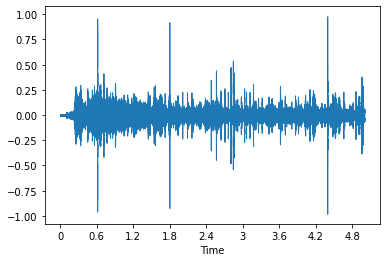

In [159]:
filename = valid[valid['category']=='toilet_flush'].iloc[0]['filename']
wav, sr = librosa.load('audio/'+filename, sr=None)
librosa.display.waveshow(wav, sr= sr)

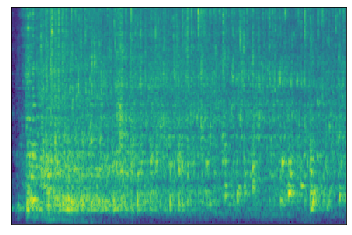

In [160]:
librosa.display.specshow(spec_to_image(get_melspectrogram_db('audio/'+filename, sr)), cmap='viridis')

In [164]:
train_data = ESC50Data('audio', train, 'filename', 'category')

100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:02<00:00, 45.33it/s]


In [166]:
print (np.shape(train_data.data))

(128, 1, 128, 431)


In [168]:
train_data_3d = ESC50Data_3d('audio', train, 'filename', 'category')

100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:02<00:00, 44.16it/s]


In [169]:
print (np.shape(train_data_3d.data))

(128, 3, 128, 431)


In [103]:
valid_data = ESC50Data('audio', valid, 'filename', 'category')

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 43.95it/s]


In [104]:
print (np.shape(valid_data.data))

(32, 1, 128, 431)


In [105]:
valid_data_3d = ESC50Data_3d('audio', valid, 'filename', 'category')

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.58it/s]


In [106]:
print (np.shape(valid_data_3d.data))

(32, 3, 128, 431)


In [107]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=16, shuffle=True)
train_loader_3d = DataLoader(train_data_3d, batch_size=16, shuffle=True)
valid_loader_3d = DataLoader(valid_data_3d, batch_size=16, shuffle=True)

In [108]:
if torch.cuda.is_available():
    device=torch.device('cuda:0')
else:
    device=torch.device('cpu')

In [111]:
model = ESC50Model(input_shape=(1,128,431), batch_size=16, num_cats=50).to(device)

In [136]:
def setlr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

In [137]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 2e-5
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
epochs = 6
train_losses = []
valid_losses = []

In [138]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, change_lr=None):
    for epoch in tqdm(range(1,epochs+1)):
        model.train()
        batch_losses=[]
        if change_lr:
            optimizer = change_lr(optimizer, epoch)
        for i, data in enumerate(train_loader):
            x, y = data
            optimizer.zero_grad()
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)
            y_hat = model(x)
            loss = loss_fn(y_hat, y)
            loss.backward()
            batch_losses.append(loss.item())
            optimizer.step()
        train_losses.append(batch_losses)
        print(f'Epoch - {epoch} Train-Loss : {np.mean(train_losses[-1])}')
        model.eval()
        batch_losses=[]
        trace_y = []
        trace_yhat = []
        for i, data in enumerate(valid_loader):
            x, y = data
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)
            y_hat = model(x)
            loss = loss_fn(y_hat, y)
            trace_y.append(y.cpu().detach().numpy())
            trace_yhat.append(y_hat.cpu().detach().numpy())      
            batch_losses.append(loss.item())
        valid_losses.append(batch_losses)
        trace_y = np.concatenate(trace_y)
        trace_yhat = np.concatenate(trace_yhat)
        accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)
        print(f'Epoch - {epoch} Valid-Loss : {np.mean(valid_losses[-1])} Valid-Accuracy : {accuracy}')

In [36]:
def lr_decay(optimizer, epoch):
    if epoch%20==0:
        new_lr = learning_rate / (10**(epoch//20))
        optimizer = setlr(optimizer, new_lr)
        print(f'Changed learning rate to {new_lr}')
    return optimizer

train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, lr_decay)

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch - 1 Train-Loss : 2.2302610635757447


 17%|██████████████                                                                      | 1/6 [00:57<04:48, 57.67s/it]

Epoch - 1 Valid-Loss : 2.5418008963267007 Valid-Accuracy : 0.2
Epoch - 2 Train-Loss : 0.7662829905748367


 33%|████████████████████████████                                                        | 2/6 [01:59<04:00, 60.00s/it]

Epoch - 2 Valid-Loss : 1.8967994451522827 Valid-Accuracy : 0.275
Epoch - 3 Train-Loss : 0.48258721828460693


 50%|██████████████████████████████████████████                                          | 3/6 [02:56<02:56, 58.81s/it]

Epoch - 3 Valid-Loss : 2.3024179935455322 Valid-Accuracy : 0.275
Epoch - 4 Train-Loss : 0.15565061438828706


 67%|████████████████████████████████████████████████████████                            | 4/6 [03:54<01:56, 58.26s/it]

Epoch - 4 Valid-Loss : 0.8690386811892191 Valid-Accuracy : 0.675
Epoch - 5 Train-Loss : 0.0800501924008131


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [04:50<00:57, 57.55s/it]

Epoch - 5 Valid-Loss : 0.5486640830834707 Valid-Accuracy : 0.85
Epoch - 6 Train-Loss : 0.05800482574850321


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [05:47<00:00, 57.88s/it]

Epoch - 6 Valid-Loss : 0.7240700225035349 Valid-Accuracy : 0.8


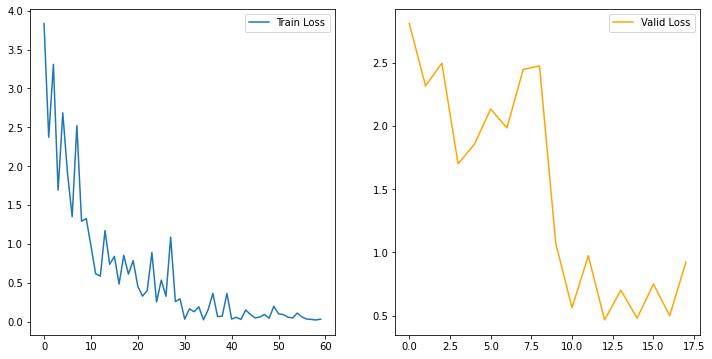

In [37]:
tl = np.asarray(train_losses).ravel()
vl = np.asarray(valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])


In [58]:
from torchvision.models import resnet34, ResNet34_Weights
weights = ResNet34_Weights.DEFAULT
resnet_model_34 = resnet34(weights=weights)
resnet_model_34.fc = nn.Linear(512,50)
resnet_model_34.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet_model_34 = resnet_model.to(device)

In [59]:
learning_rate = 2e-4
optimizer = optim.Adam(resnet_model.parameters(), lr=learning_rate)
epochs = 5
loss_fn = nn.CrossEntropyLoss()
resnet_34_train_losses=[]
resnet_34_valid_losses=[]
def lr_decay(optimizer, epoch):
    if epoch%10==0:
        new_lr = learning_rate / (10**(epoch//10))
        optimizer = setlr(optimizer, new_lr)
        print(f'Changed learning rate to {new_lr}')
    return optimizer

train(resnet_model_34, loss_fn, train_loader, valid_loader, epochs, optimizer, resnet_34_train_losses, resnet_34_valid_losses, lr_decay)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Epoch - 1 Train-Loss : 1.700729387998581


 20%|████████████████▊                                                                   | 1/5 [00:52<03:30, 52.67s/it]

Epoch - 1 Valid-Loss : 1.877700646718343 Valid-Accuracy : 0.525
Epoch - 2 Train-Loss : 0.4879570662975311


 40%|█████████████████████████████████▌                                                  | 2/5 [01:46<02:40, 53.56s/it]

Epoch - 2 Valid-Loss : 0.7348782618840536 Valid-Accuracy : 0.75
Epoch - 3 Train-Loss : 0.19798045121133329


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [02:40<01:46, 53.42s/it]

Epoch - 3 Valid-Loss : 0.6088836491107941 Valid-Accuracy : 0.85
Epoch - 4 Train-Loss : 0.07142559364438057


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [03:32<00:52, 52.98s/it]

Epoch - 4 Valid-Loss : 0.5014254028598467 Valid-Accuracy : 0.85
Epoch - 5 Train-Loss : 0.1332551441155374


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:20<00:00, 52.06s/it]

Epoch - 5 Valid-Loss : 1.1549756228923798 Valid-Accuracy : 0.8


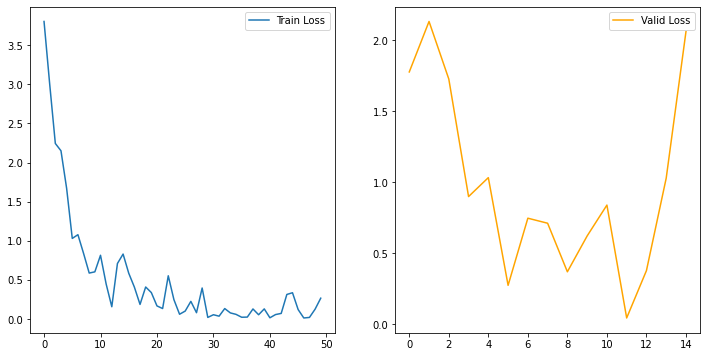

In [61]:
tl = np.asarray(resnet_34_train_losses).ravel()
vl = np.asarray(resnet_34_valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])


In [77]:
from torchvision.models import resnet50, ResNet50_Weights
weights = ResNet50_Weights.DEFAULT
resnet_model_50 = resnet50(weights=weights)
resnet_model_50.fc = nn.Linear(2048,16)
resnet_model_50.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding= (2, 2), bias=False)
resnet_model_50 = resnet_model_50.to(device)

In [78]:
learning_rate = 2e-4
optimizer = optim.Adam(resnet_model_50.parameters(), lr=learning_rate)
epochs = 6
loss_fn = nn.CrossEntropyLoss()
resnet_50_train_losses=[]
resnet_50_valid_losses=[]
def lr_decay(optimizer, epoch):
    if epoch%10==0:
        new_lr = learning_rate / (10**(epoch//10))
        optimizer = setlr(optimizer, new_lr)
        print(f'Changed learning rate to {new_lr}')
    return optimizer

train(resnet_model_50, loss_fn, train_loader, valid_loader, epochs, optimizer, resnet_50_train_losses, resnet_50_valid_losses, lr_decay)

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch - 1 Train-Loss : 2.2590120673179626


 17%|██████████████                                                                      | 1/6 [01:16<06:24, 76.86s/it]

Epoch - 1 Valid-Loss : 2.1880712509155273 Valid-Accuracy : 0.35
Epoch - 2 Train-Loss : 1.0217680156230926


 33%|████████████████████████████                                                        | 2/6 [02:34<05:09, 77.43s/it]

Epoch - 2 Valid-Loss : 1.0700214902559917 Valid-Accuracy : 0.775
Epoch - 3 Train-Loss : 0.31051438078284266


 50%|██████████████████████████████████████████                                          | 3/6 [03:57<04:00, 80.04s/it]

Epoch - 3 Valid-Loss : 0.7129810353120168 Valid-Accuracy : 0.75
Epoch - 4 Train-Loss : 0.20688728168606757


 67%|████████████████████████████████████████████████████████                            | 4/6 [05:22<02:43, 81.87s/it]

Epoch - 4 Valid-Loss : 0.5638888974984487 Valid-Accuracy : 0.825
Epoch - 5 Train-Loss : 0.0933641690760851


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [06:45<01:22, 82.21s/it]

Epoch - 5 Valid-Loss : 0.4372876435518265 Valid-Accuracy : 0.85
Epoch - 6 Train-Loss : 0.03663521828129888


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [08:08<00:00, 81.39s/it]

Epoch - 6 Valid-Loss : 0.413409819205602 Valid-Accuracy : 0.875


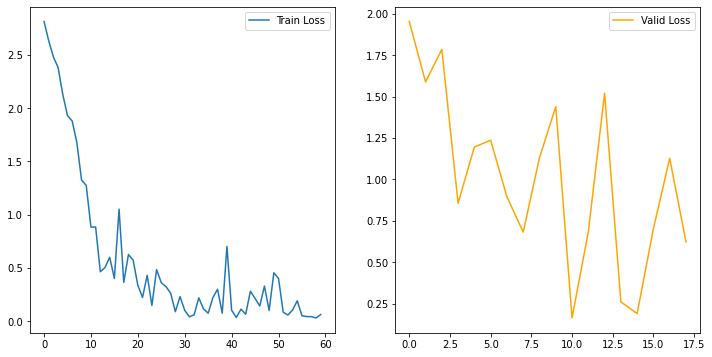

In [70]:
tl = np.asarray(resnet_50_train_losses).ravel()
vl = np.asarray(resnet_50_valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])


In [115]:
from torchvision.models import densenet201, DenseNet201_Weights
weights = DenseNet201_Weights.DEFAULT
densenet_model_201 = densenet201(weights=weights)
# densenet_model_201.fc = nn.Linear(2048,16)
# densenet_model_201.conv1 = nn.Conv2d(1, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
densenet_model_201 = densenet_model_201.to(device)

In [116]:
learning_rate = 2e-4
optimizer = optim.Adam(densenet_model_201.parameters(), lr=learning_rate)
epochs = 6
loss_fn = nn.CrossEntropyLoss()
densenet_201_train_losses=[]
densenet_201_valid_losses=[]
def lr_decay(optimizer, epoch):
    if epoch%10==0:
        new_lr = learning_rate / (10**(epoch//10))
        optimizer = setlr(optimizer, new_lr)
        print(f'Changed learning rate to {new_lr}')
    return optimizer

train(densenet_model_201, loss_fn, train_loader_3d, valid_loader_3d, epochs, optimizer, densenet_201_train_losses, densenet_201_valid_losses, lr_decay)

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch - 1 Train-Loss : 4.05519363284111


 17%|██████████████                                                                      | 1/6 [01:34<07:51, 94.22s/it]

Epoch - 1 Valid-Loss : 4.767622709274292 Valid-Accuracy : 0.1875
Epoch - 2 Train-Loss : 0.2522083418443799


 33%|████████████████████████████                                                        | 2/6 [03:12<06:25, 96.41s/it]

Epoch - 2 Valid-Loss : 1.3154155015945435 Valid-Accuracy : 0.8125
Epoch - 3 Train-Loss : 0.11155650817090645


 50%|██████████████████████████████████████████                                          | 3/6 [04:55<04:58, 99.40s/it]

Epoch - 3 Valid-Loss : 0.47940385341644287 Valid-Accuracy : 0.9375
Epoch - 4 Train-Loss : 0.0704897926771082


 67%|███████████████████████████████████████████████████████▎                           | 4/6 [06:47<03:29, 104.58s/it]

Epoch - 4 Valid-Loss : 0.3217227905988693 Valid-Accuracy : 0.875
Epoch - 5 Train-Loss : 0.11124024912714958


 83%|█████████████████████████████████████████████████████████████████████▏             | 5/6 [08:42<01:48, 108.38s/it]

Epoch - 5 Valid-Loss : 0.24440762493759394 Valid-Accuracy : 0.9375
Epoch - 6 Train-Loss : 0.16181881818920374


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [10:25<00:00, 104.19s/it]

Epoch - 6 Valid-Loss : 0.2558832988142967 Valid-Accuracy : 0.9375


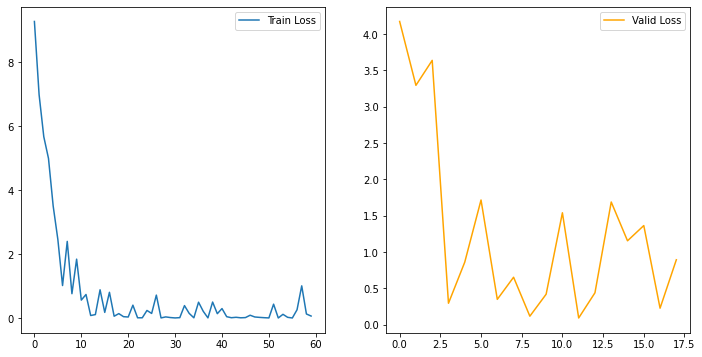

In [64]:
tl = np.asarray(densenet_201_train_losses).ravel()
vl = np.asarray(densenet_201_valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])


In [117]:
from torchvision.models import efficientnet_v2_l, EfficientNet_V2_L_Weights
weights = EfficientNet_V2_L_Weights.DEFAULT
efficientnet_b7_model = efficientnet_v2_l(weights=weights)
# efficientnet_b7_model.fc = nn.Linear(2048,16)
# efficientnet_b7_model.conv1 = nn.Conv2d(1, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
efficientnet_b7_model = efficientnet_b7_model.to(device)

In [118]:
learning_rate = 2e-4
optimizer = optim.Adam(efficientnet_b7_model.parameters(), lr=learning_rate)
epochs = 6
loss_fn = nn.CrossEntropyLoss()
efficientnet_b7_train_losses=[]
efficientnet_b7_valid_losses=[]
def lr_decay(optimizer, epoch):
    if epoch%10==0:
        new_lr = learning_rate / (10**(epoch//10))
        optimizer = setlr(optimizer, new_lr)
        print(f'Changed learning rate to {new_lr}')
    return optimizer

train(efficientnet_b7_model, loss_fn, train_loader_3d, valid_loader_3d, epochs, optimizer, efficientnet_b7_train_losses, efficientnet_b7_valid_losses, lr_decay)

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Epoch - 1 Train-Loss : 5.085376113653183


 17%|█████████████▊                                                                     | 1/6 [04:47<23:57, 287.51s/it]

Epoch - 1 Valid-Loss : 6.928322792053223 Valid-Accuracy : 0.0625
Epoch - 2 Train-Loss : 1.1651375386863947


 33%|███████████████████████████▋                                                       | 2/6 [09:17<18:29, 277.38s/it]

Epoch - 2 Valid-Loss : 1.7486936450004578 Valid-Accuracy : 0.75
Epoch - 3 Train-Loss : 0.38169546658173203


 50%|█████████████████████████████████████████▌                                         | 3/6 [13:42<13:35, 271.80s/it]

Epoch - 3 Valid-Loss : 0.5855819135904312 Valid-Accuracy : 0.90625
Epoch - 4 Train-Loss : 0.15523304013186134


 67%|███████████████████████████████████████████████████████▎                           | 4/6 [18:07<08:58, 269.11s/it]

Epoch - 4 Valid-Loss : 0.517762802541256 Valid-Accuracy : 0.96875
Epoch - 5 Train-Loss : 0.09239360856008716


 83%|█████████████████████████████████████████████████████████████████████▏             | 5/6 [22:33<04:27, 267.87s/it]

Epoch - 5 Valid-Loss : 0.5884435102343559 Valid-Accuracy : 0.90625
Epoch - 6 Train-Loss : 0.09833108860766515


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [26:59<00:00, 269.84s/it]

Epoch - 6 Valid-Loss : 0.7203328460454941 Valid-Accuracy : 0.875


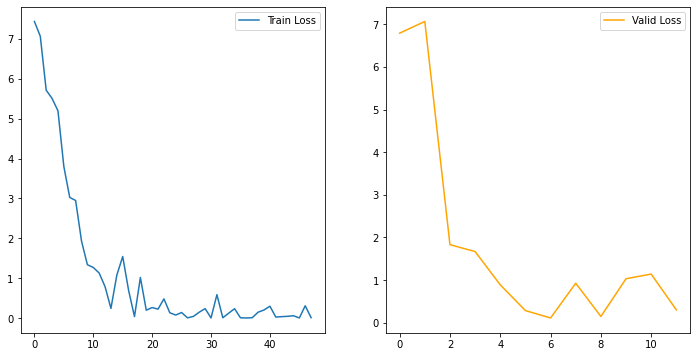

In [119]:
tl = np.asarray(efficientnet_b7_train_losses).ravel()
vl = np.asarray(efficientnet_b7_valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])
